# CASE 1: **Double Well potential**

### 1. Inizialization

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kB
from numpy.random import randn as gauss
from numpy.random import rand as uniform

case_study = '2D_double-well'

### 2. Generate Trajectories


Here it's defined the function that simulates the motion of the Brownian particle in the force field. Particularly, in this case of study, we consider a Brownian particle in a double well trap. The trajectory of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

Comments:

1. The function that simulates the trajectories is *simulate_trajectory*.
2. Lambda functions scale_inputs, rescale_inputs, scale_targets, and rescale_targets must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
## define parameters
normal_values = True

In [6]:
if normal_values == True:
    
    ### follows the parameters used in DeepCalib
    
    ### Physical parameters 
    R = 1e-7                                # Radius of the Brownian particle [m]
    eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
    T = 300                                 # Temperature [K]
    L0 = 2e-6                               # Reference distance from middle to one minimum [m]
    H0 = kB*300                             # Barrier height [Joule]
    gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

    ### Simulation parameters
    N = 1000                   # Number of samples of the trajectory
    Dt = 1e-2                  # Timestep 
    oversampling = 5           # Simulation oversampling
    offset = 1000              # Number of equilibration timesteps
    batch_size = 32            # Number of trajectories

    ### Define functions to scale and rescale inputs
    scale_inputs = lambda x, y: [x * 1e+6, y * 1e+6]        # Scales input trajectory to order 1
    rescale_inputs = lambda scaled_x, scaled_y: [scaled_x * 1e-6,
                                   scaled_y * 1e-6]     # Rescales input trajectory to physical units

    ### Define function to scale and rescale targets
    scale_targets = lambda L, H: [L/L0 -1, np.log(H / H0)]                        # Scales targets to order 1
    rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0*1e6, 
                                                np.exp(scaled_H) * H0/kB/300] # Inverse of targets_scaling

    def simulate_trajectory(batch_size=batch_size, 
                        T=T,
                        H0=H0,
                        L0=L0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset):
    
        ### Randomize trajectory parameters
        L = L0 * (uniform(batch_size)+.5) 
        H = H0 * 10**(uniform(batch_size)*1.75 - .75)       # Generates random values for computing the stiffness
        gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

        ### Simulate
        dt = Dt / oversampling                 # time step of the simulation
        x = np.zeros((batch_size, N))          # initialization of the x array
        y = np.zeros((batch_size, N))          # initialization of the y array
        k0 = 4*H/L**2 
        k1 = 4*H/L**4
        D = kB * T / gamma                     # diffusion coefficient
        C1 = +k0 / gamma * dt                  # drift coefficient of the Langevin equation
        C2 = -k1 / gamma * dt                  # drift coefficient of the Langevin equation
        C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
        X = x[:, 0]
        Y = y[:, 0]
        n = 0
        
        for t in range(offset):                      # Offset (for some prerun before running)
            X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
            Y = Y + C1 * Y + C2 * Y**3 + C3 * gauss(batch_size)
            
        for t in range(int(N * oversampling)):            # Simulation 
            X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
            Y = Y + C1 * Y + C2 * Y**3 + C3 * gauss(batch_size)               
            if t % oversampling == 0:                # We save every oversampling^th values 
                x[:, n] = X 
                y[:, n] = Y
                n += 1
                
        inputs = np.swapaxes(scale_inputs(*[x,y]),0,1)
        inputs_real = np.swapaxes([x, y],0,1)
        targets = np.swapaxes(scale_targets(*[L, H]),0,1)
        target_reals = np.swapaxes([L*1e6, H/kB/300],0,1)

        return inputs, inputs_real, targets, target_reals




else:
    ### larger values: natural units
    
    ### Physical parameters 
    R = 1                                   # Radius of the Brownian particle [m]
    eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
    kB = 1                                  # Boltzmann constant
    T = 1                                   # Temperature [K]
    L0 = 5                                  # Reference stiffness [fN \mu m ^-1]
    H0 = 4
    gamma0 = 1                              # Reference friction coefficient [kg s^-1]

    ### Simulation parameters
    N = 1000                         # Number of samples of the trajectory
    Dt = 2e-1                       # Timestep 
    oversampling = 5                  # Simulation oversampling
    offset = 1000                     # Number of equilibration timesteps
    batch_size = 32                   # Number of trajectories

    ### Define functions to scale and rescale inputs
    scale_inputs = lambda x, y: [x * 1e+6, y * 1e+6]        # Scales input trajectory to order 1
    rescale_inputs = lambda scaled_x, scaled_y: [scaled_x * 1e-6,
                                   scaled_y * 1e-6]     # Rescales input trajectory to physical units

    ### Define function to scale and rescale targets
    scale_targets = lambda L, H: [L/L0 -1, np.log(H / H0)]                        # Scales targets to order 1
    rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0*1e6, 
                                                np.exp(scaled_H) * H0/kB/300] # Inverse of targets_scaling

    def simulate_trajectory(batch_size=batch_size, 
                        T=T,
                        H0=H0,
                        L0=L0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset):
    
        ### Randomize trajectory parameters
        L = L0 * (uniform(batch_size)+.5) 
        H = H0 * 10**(uniform(batch_size)*1.75 - .75)       # Generates random values for computing the stiffness
        gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

        ### Simulate
        dt = Dt / oversampling                 # time step of the simulation
        x = np.zeros((batch_size, N))          # initialization of the x array
        y = np.zeros((batch_size, N))          # initialization of the y array
        k0 = 4*H/L**2 
        k1 = 4*H/L**4
        D = kB * T / gamma                     # diffusion coefficient
        C1 = +k0 / gamma * dt                  # drift coefficient of the Langevin equation
        C2 = -k1 / gamma * dt                  # drift coefficient of the Langevin equation
        C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
        X = x[:, 0]
        Y = y[:, 0]
        n = 0
        
        for t in range(offset):                      # Offset (for some prerun before running)
            X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
            Y = Y + C1 * Y + C2 * Y**3 + C3 * gauss(batch_size)
            
        for t in range(int(N * oversampling)):            # Simulation 
            X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
            Y = Y + C1 * Y + C2 * Y**3 + C3 * gauss(batch_size)               
            if t % oversampling == 0:                # We save every oversampling^th values 
                x[:, n] = X 
                y[:, n] = Y
                n += 1
                
        inputs = np.swapaxes(scale_inputs(*[x,y]),0,1)
        inputs_real = np.swapaxes([x, y],0,1)
        targets = np.swapaxes(scale_targets(*[L, H]),0,1)
        target_reals = np.swapaxes([L*1e6, H/kB/300],0,1)

        return inputs, inputs_real, targets, target_reals

### 3. Plot Trajectory Simulation

In [6]:
def plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show):
    """
    
    Inputs:   
    
    simulate_trajectory:                 trajectroy generator function
    number_of_trajectories_to_show:      number of trajectories to be plotted as sample  
        
    Output:
    
    This function does not return any outputs, it only plots some sample trajectories to preview the generator function
   
    """ 
    import matplotlib.pyplot as plt
    inputs, targets = simulate_trajectory(number_of_trajectories_to_show)
    
    if len(inputs.names)>1:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))    
            number_subplots = len(inputs.names)
            for subplot in range(number_subplots):
                plt.subplot(1, number_subplots, subplot+1)
                plt.plot(scaled_values[subplot])
                plt.xlabel('timestep', fontsize=18)
                plt.ylabel(inputs.scalings[subplot], fontsize=18)   

            title_text = 'Parameters: ' 
            for parameter in range(len(target_values)):
                title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
            plt.title(title_text, fontsize=18)  

    else:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))
            plt.plot(scaled_values)
            plt.xlabel('timestep', fontsize=18)
            plt.ylabel(inputs.scalings[0], fontsize=18)
            title_text = 'Parameters: ' 
            if len(targets.names)>1:
                for parameter in range(len(targets.names)):
                    title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
                plt.title(title_text, fontsize=18)  
            else:
                plt.title(title_text + ' ' + targets.names[0] + ' = ' + '%1.2e' % target_values , fontsize=18)  

In [7]:
### Show some examples of simulated trajectories
number_of_trajectories_to_show= 10
plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

ValueError: too many values to unpack (expected 2)

(2, 1000)


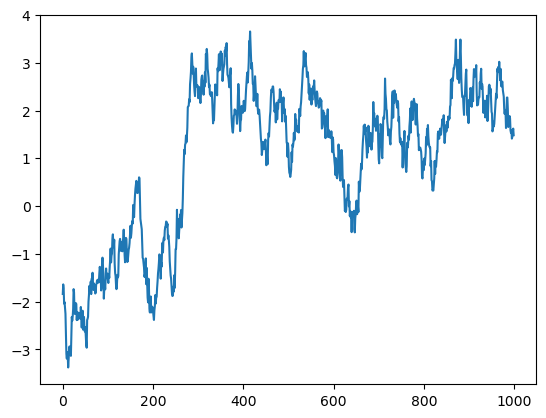

In [8]:
trajectory, _, target, target_real = simulate_trajectory(batch_size)
print(trajectory[0,:].shape)
plt.plot(trajectory[0,:][0])

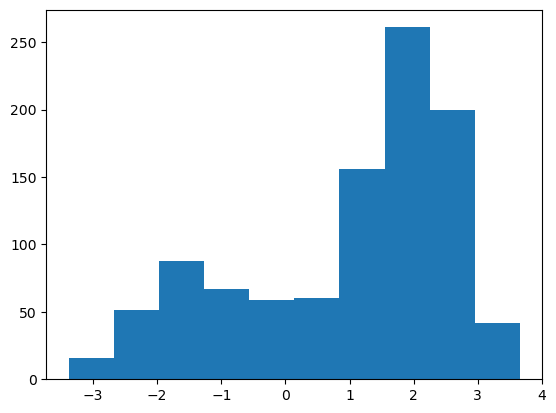

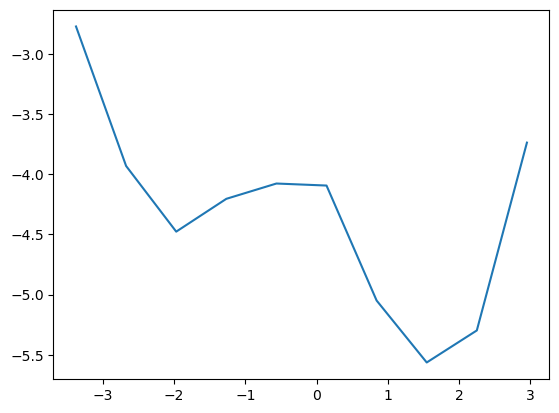

In [9]:
a=plt.hist(trajectory[0][0,:])
plt.show()

a_1,a_2 = a[0], a[1]
plt.plot(a_2[:-1],-np.log(a_1))
plt.show()

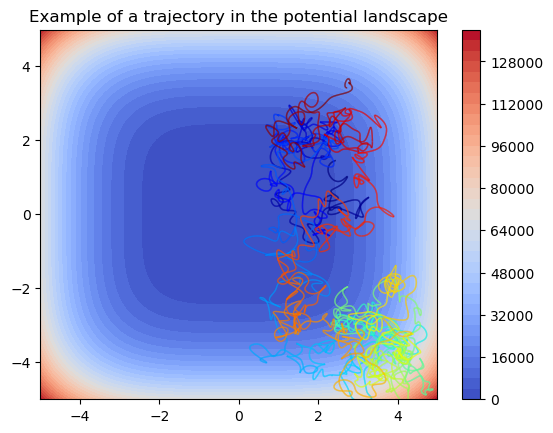

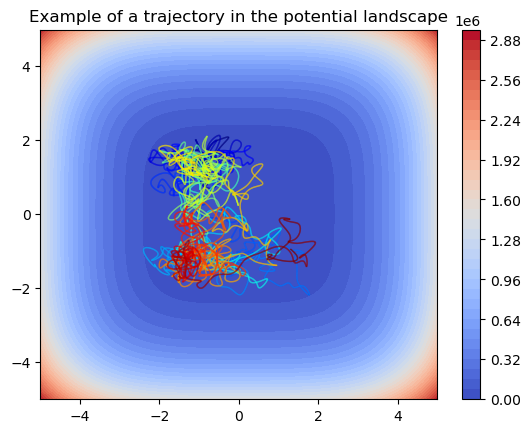

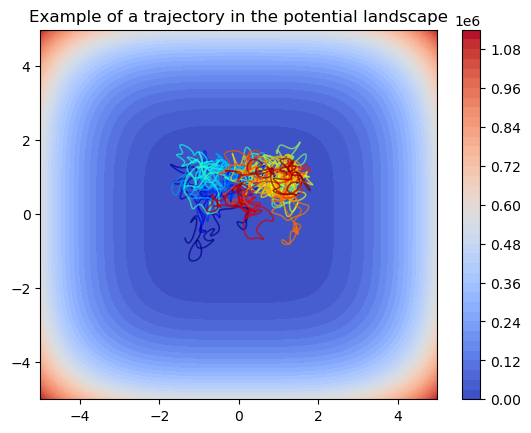

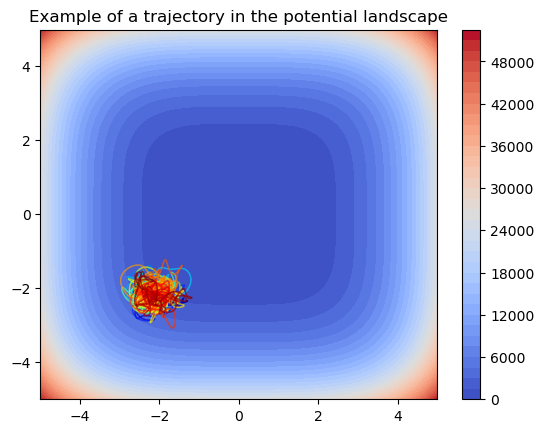

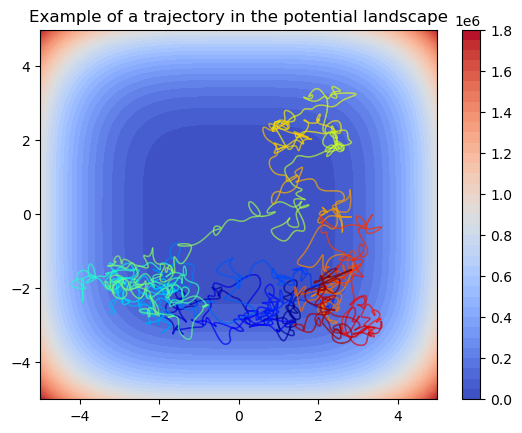

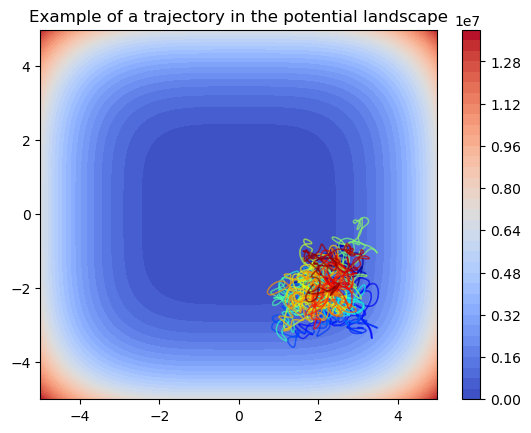

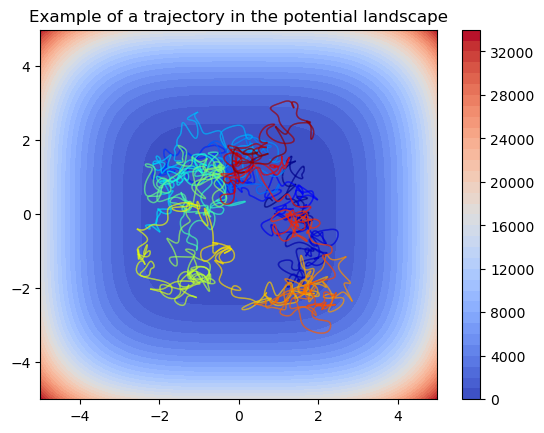

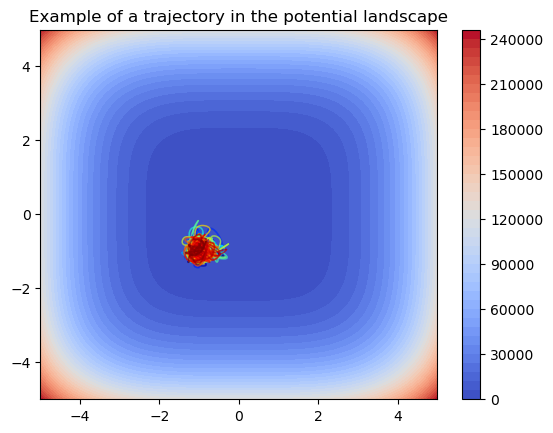

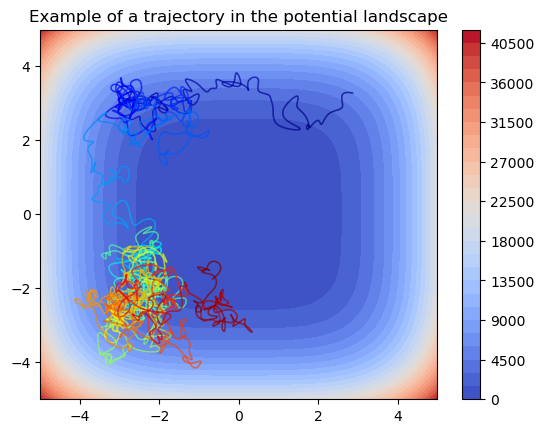

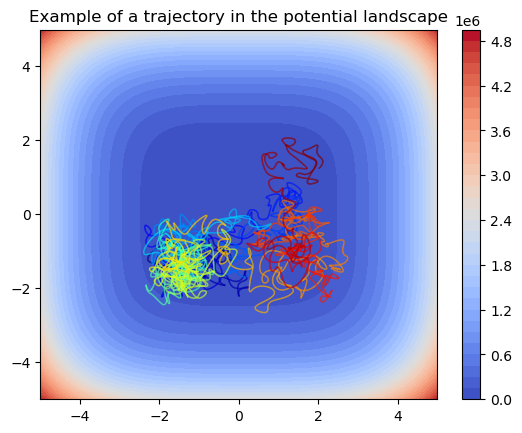

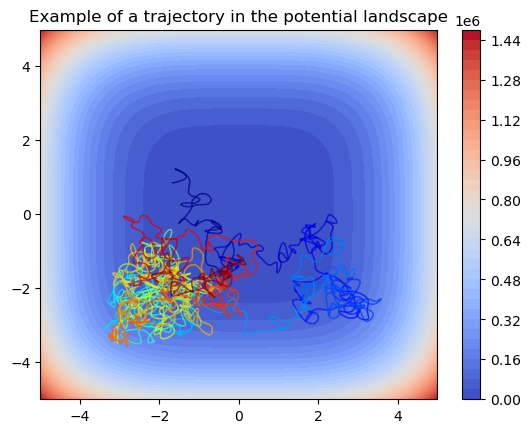

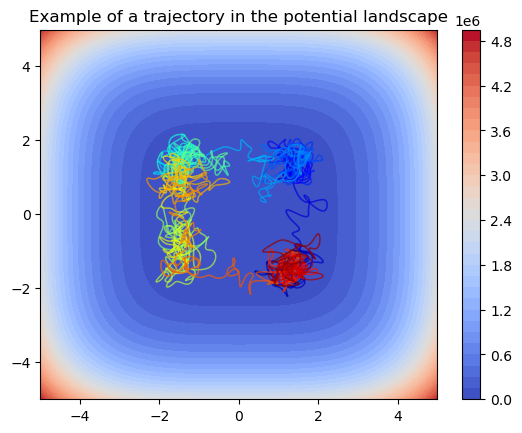

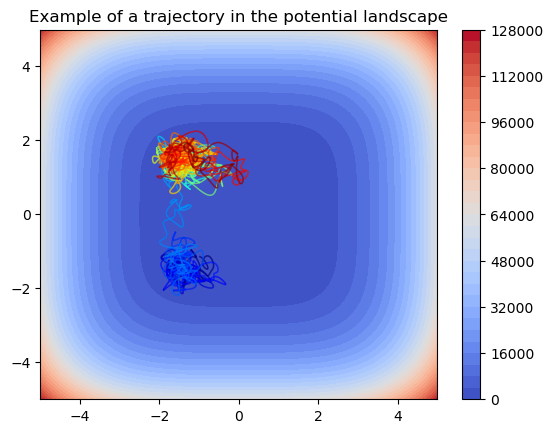

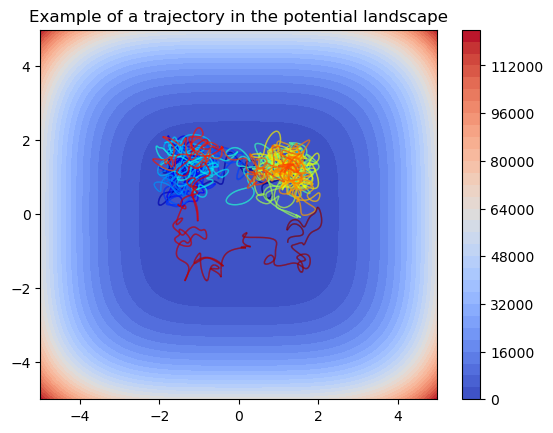

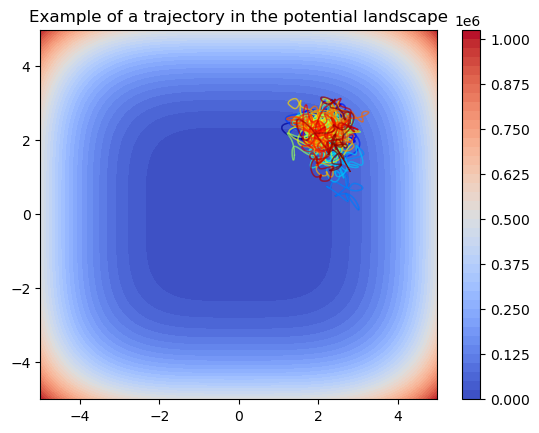

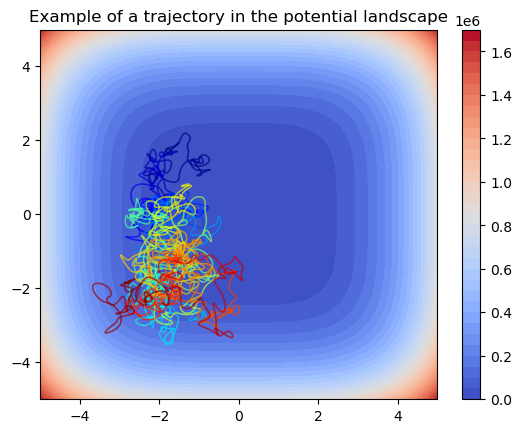

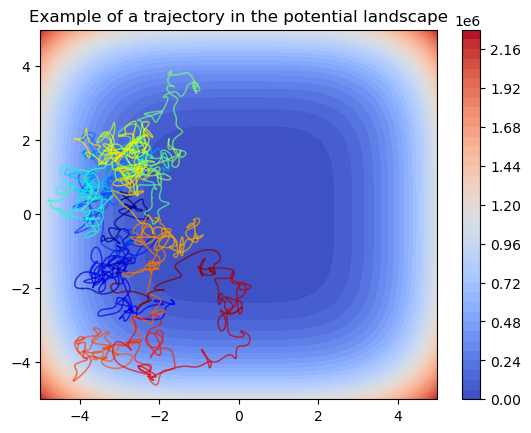

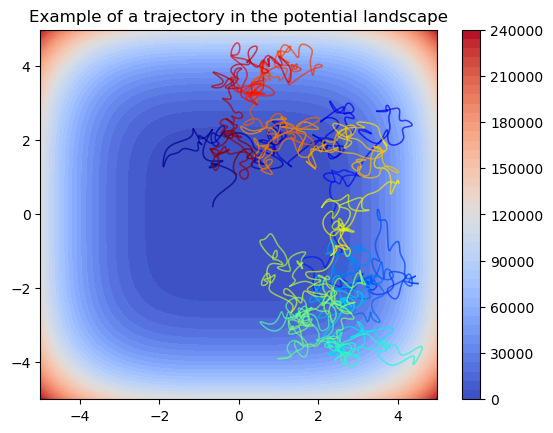

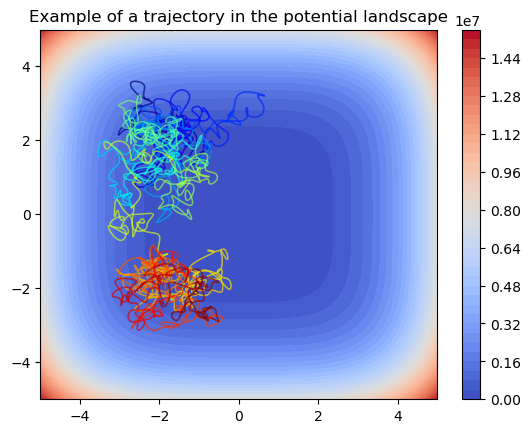

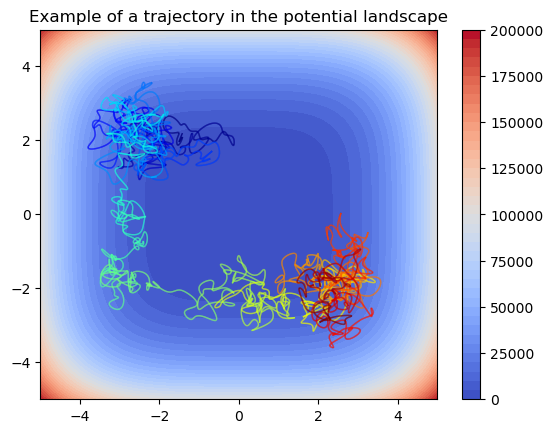

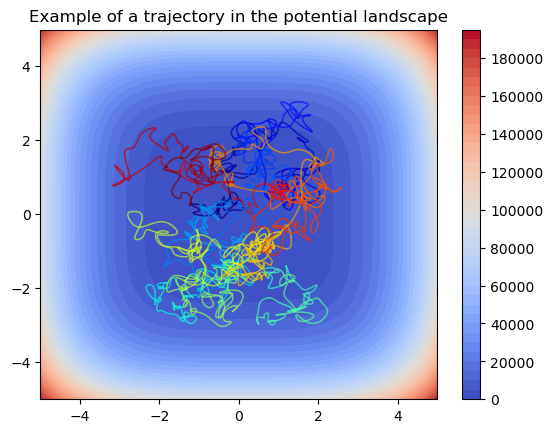

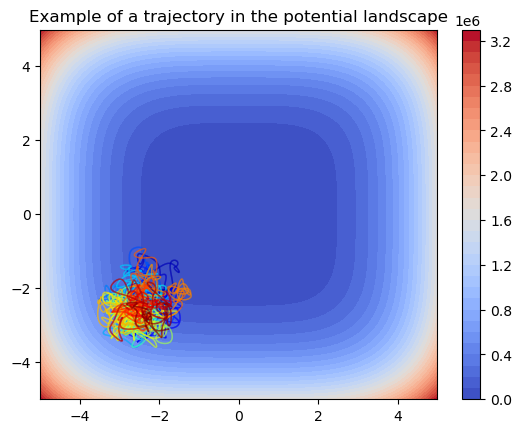

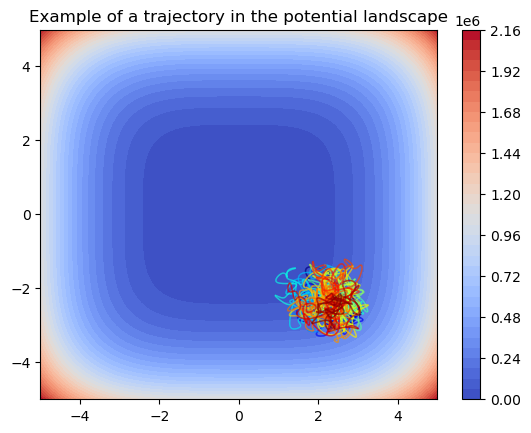

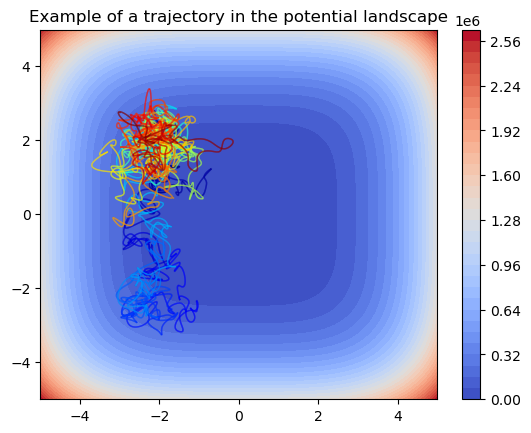

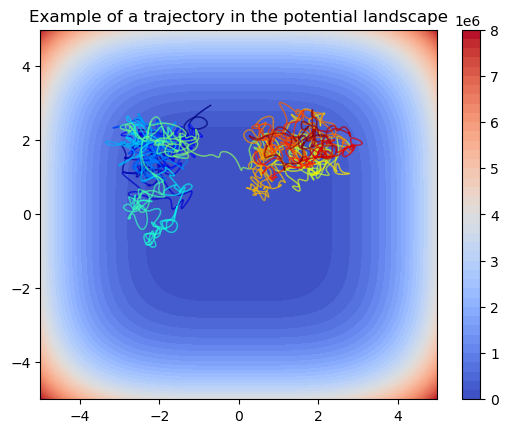

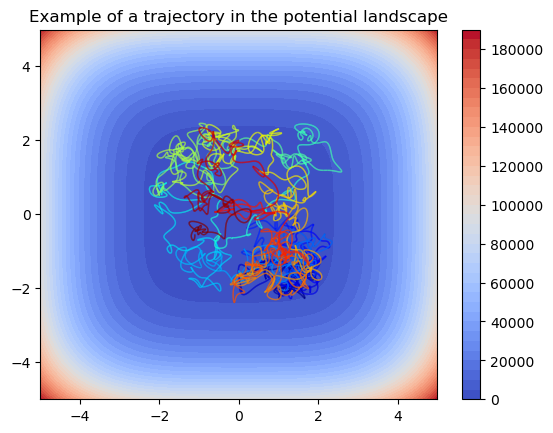

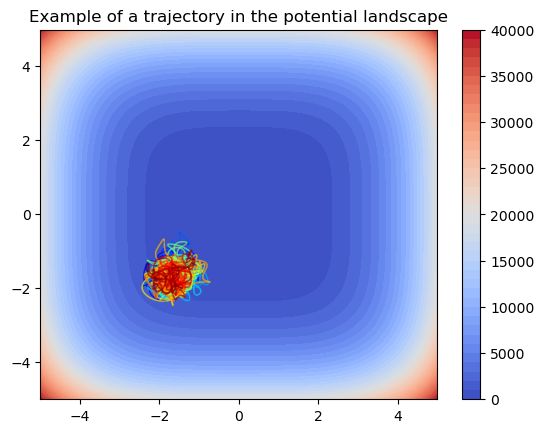

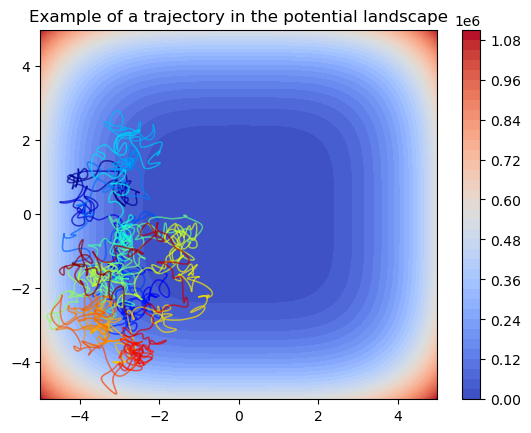

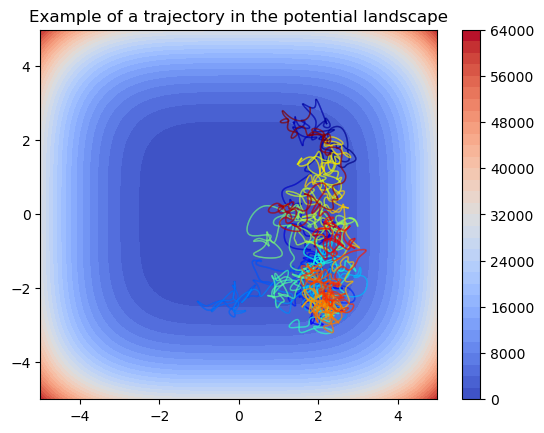

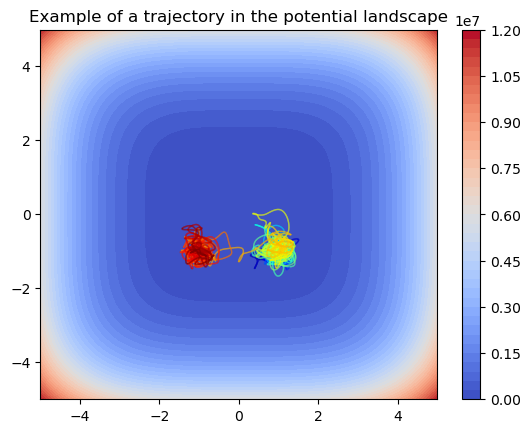

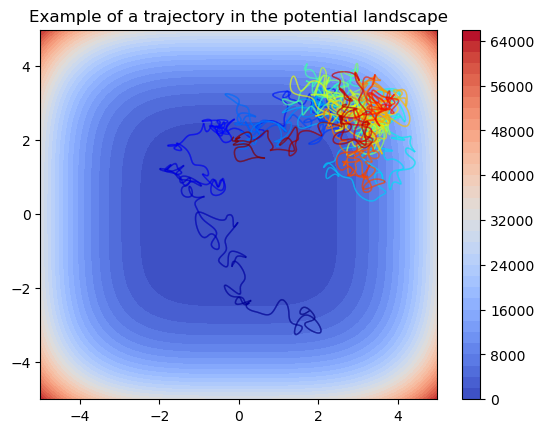

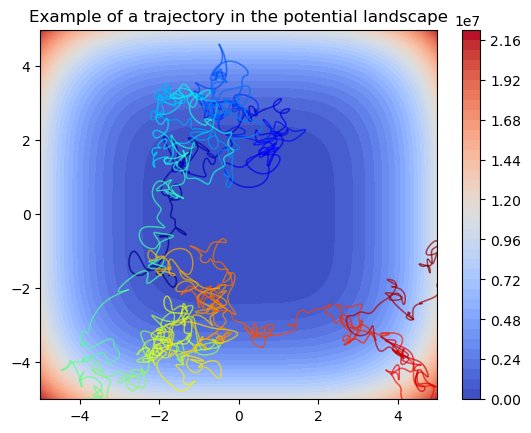

In [11]:
 import numpy as np
 import scipy
 import matplotlib.pyplot as plt
 from matplotlib.collections import LineCollection

 results = simulate_trajectory()
 trajectory = results[0]

 L = L0 * (uniform(batch_size)+.5) 
 H = H0 * 10**(uniform(batch_size)*1.75 - .75)

 for i in range(32):
    x = np.arange(-5, 5, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)

    V = V = H[i]*((X/L[i])**2 - 1)**2 + H[i]*((Y/L[i])**2 - 1)**2 

    fig, ax = plt.subplots(1, 1)
    ax.set_title("Example of a trajectory in the potential landscape")

    cb = ax.contourf(x, y, V, levels=40, cmap='coolwarm')
    x = trajectory[i][0,:]
    y = trajectory[i][1,:]
    f, u = scipy.interpolate.splprep([x, y], s=0, per=False)
    xint, yint = scipy.interpolate.splev(np.linspace(0, 1, 50000), f)

    points = np.stack([xint, yint]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    coll = LineCollection(segments, cmap='jet')
    coll.set_array(np.linspace(0, 1, num=len(points), endpoint=True))
    coll.set_linewidth(1)
    ax.add_collection(coll)

    fig.colorbar(cb)
    plt.show()

### 4. COMPILE Deep Neural Network

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.

Comments:

1. The parameter input_shape determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter conv_layers_dimensions determines the number and size of LSTM layers.
3. The parameter number_of_outputs determines the number of outputs, i.e. the number of force field parameters to be estimated.

#### GRU with attention

CREATE MODEL

In [12]:
from src_models import models_DNN, train_DNN, test_DNN

2023-06-13 12:32:19.217644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
### Define parameters of the deep learning network
input_shape = (40, 50)      
gru_layers_dimensions = (500, 250, 50)
number_of_outputs = 2

DNN = 'GRU'
attention = True

### Create deep learning network
network = models_DNN.create_deep_learning_network(input_shape, gru_layers_dimensions, number_of_outputs, 
                                                      DNN,
                                                      attention)

### Print deep learning network summary
network.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 40, 50)]          0         
                                                                 
 gru_0 (GRU)                 (None, 40, 500)           828000    
                                                                 
 gru_1 (GRU)                 (None, 40, 250)           564000    
                                                                 
 attention_7 (Attention)     (None, 250)               290       
                                                                 
 output (Dense)              (None, 2)                 502       
                                                                 
Total params: 1,392,792
Trainable params: 1,392,792
Non-trainable params: 0
_________________________________________________________________


### 5. TRAIN Deep Neural Network

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:

The parameter sample_sizes determines the sizes of the batches of trajectories used in the training.
The parameter iteration_numbers determines the numbers of batches used in the training.
The parameter verbose determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [24]:
%%time

sample_sizes = (32, 128, 512)#(32, 128, 512, 2048),
iteration_numbers = (3001, 2001, 1001)#(1001, 2001, 3001),#(3001, 2001, 1001, 101),
#verbose = .1

training_history = train_DNN.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE     0.9224   MAE     0.7379   Time 3111.389399 ms
Sample size     32   iteration number     11   MSE     0.6534   MAE     0.6731   Time 751.622915 ms
Sample size     32   iteration number     21   MSE     0.3753   MAE     0.4866   Time 945.596218 ms
Sample size     32   iteration number     31   MSE     0.3488   MAE     0.4338   Time 1227.064610 ms
Sample size     32   iteration number     41   MSE     0.2776   MAE     0.3642   Time 1170.774698 ms
Sample size     32   iteration number     51   MSE     0.2725   MAE     0.3661   Time 1263.648748 ms
Sample size     32   iteration number     61   MSE     0.1993   MAE     0.3273   Time 902.024508 ms
Sample size     32   iteration number     71   MSE     0.2957   MAE     0.3371   Time 1623.877048 ms
Sample size     32   iteration number     81   MSE     0.1535   MAE     0.2954   Time 1215.960264 ms
Sample size     32   iteration number     91   MSE     0.2299   MAE     0.3296   Time 1221.332

### 6. TEST MODEL

In [25]:
%%time

number_of_predictions_to_show = 1000
prediction_test = test_DNN.test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

1/1 [==============================] - 0s 105ms/step
CPU times: user 4min 12s, sys: 7min 59s, total: 12min 11s
Wall time: 5min 21s


### 7. Store Training and Predicted history

In [26]:
import pickle
def save_data(a, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(a, f) #, protocol=pickle.HIGHEST_PROTOCOL)
    # close file
    f.close()

#from datetime import datetime
#date = datetime.today().strftime('%Y-%m-%d')

## file name
name_train = 'training_history_{}_{}'.format(DNN, case_study)
name_pred = 'prediction_{}_test_{}'.format(DNN, case_study)

if normal_values == False:
    name_train = name_train + '_B'
    name_pred = name_pred + '_B'
if attention == True:
    name_train = name_train + '_attention'
    name_pred = name_pred + '_attention' 

# save train data
save_data(training_history, name_train)
# save test data
save_data(prediction_test, name_pred)

#load
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

### 8. Plot results

In [ ]:
training_history = load_data("")

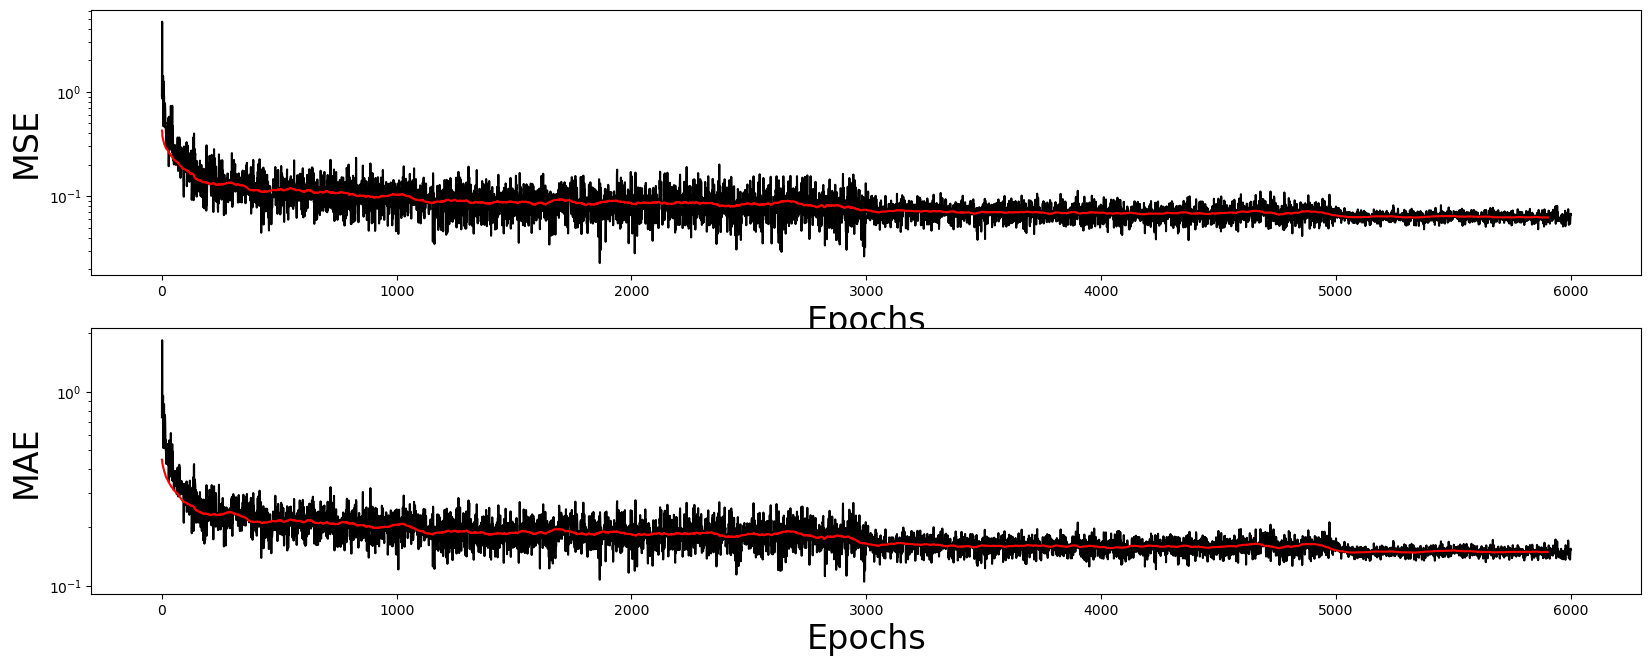

In [27]:
### Plot learning performance
number_of_timesteps_for_average = 100
train_DNN.plot_learning_performance(training_history, number_of_timesteps_for_average)

In [28]:
# average MSE and MAE
avg_mae= round(sum(training_history["MAE"])/len(training_history["MAE"]), 5)
avg_mse=round(sum(training_history["MSE"])/len(training_history["MSE"]), 5)
print('MSE: ',avg_mae)
print('MAE: ',avg_mae)

MSE:  0.18155
MAE:  0.18155


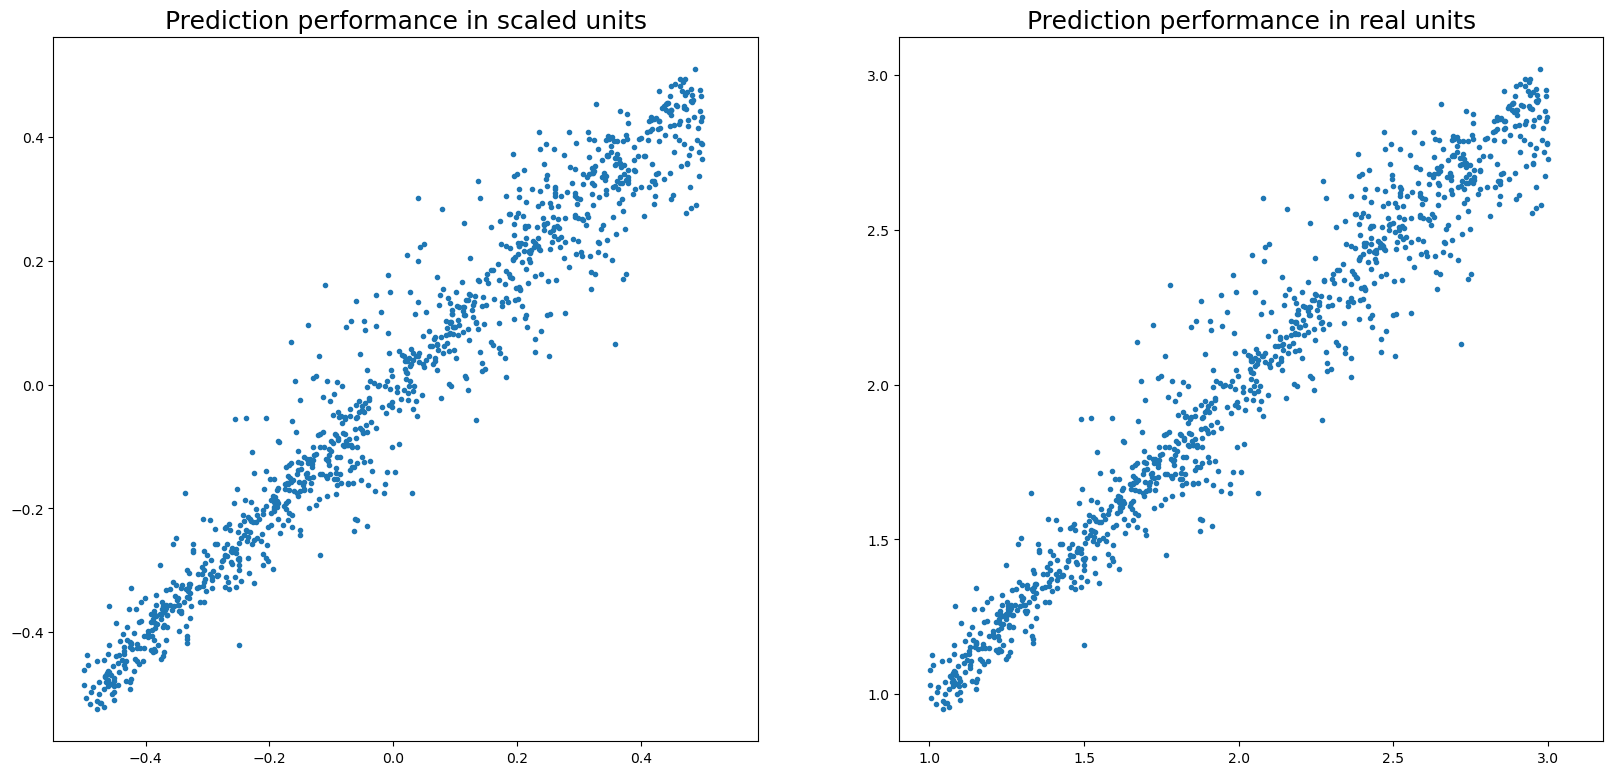

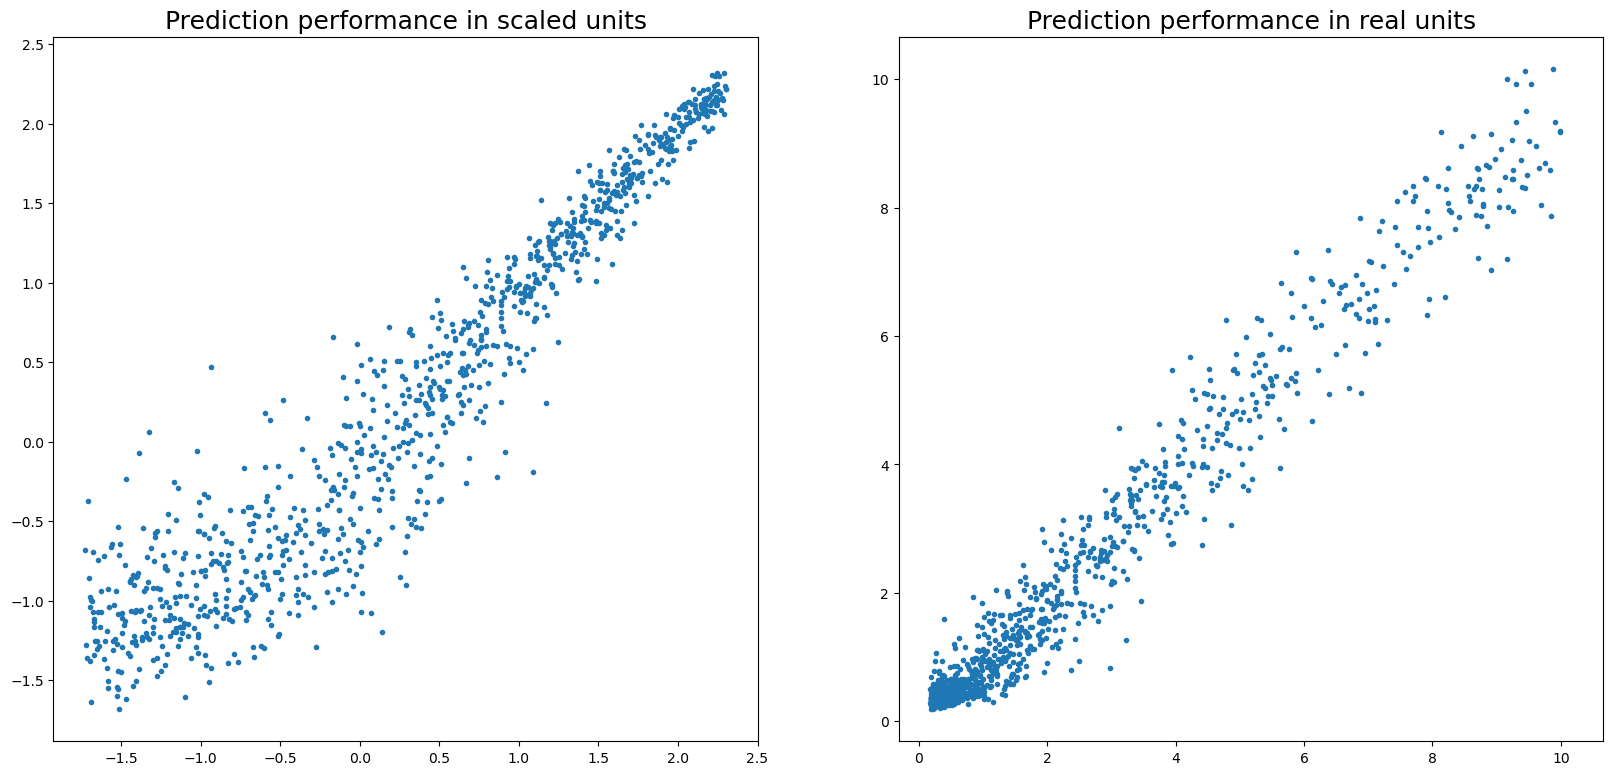

In [29]:
### Plot test performance
test_DNN.plot_test_performance(prediction_test[0], prediction_test[1], prediction_test[2], prediction_test[3], network)

In [30]:
# save DNN
save_dnn_name = 'Network-model_{}_{}'.format(DNN, case_study)

if normal_values == False:
    save_dnn_name = save_dnn_name + '_B'
if attention == True:
    save_dnn_name = save_dnn_name + '_attention'

network.save(save_dnn_name + '.h5')